<a href="https://colab.research.google.com/github/sushrutha777/BBC-News-Classification/blob/main/BBC_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bbc-text.csv to bbc-text.csv
User uploaded file "bbc-text.csv" with length 5057493 bytes


In [ ]:
import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
with open("bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

The second line (first data point) looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they

In [5]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

In [6]:
data_dir = "bbc-text.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (2225, 2)
['tech'
 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv

In [7]:
# Test the function
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,0]}")

There are 2225 sentence-label pairs in the dataset.

First sentence has 737 words.

The first 5 labels are ['tech' 'business' 'sport' 'sport' 'entertainment']


## Training - Validation Datasets


In [8]:
def train_val_datasets(data):
    '''
    Splits data into training and validation sets

    Args:
        data (np.array): array with two columns, first one is the label, the second is the text

    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(data) * TRAINING_SPLIT)

    # Slice the dataset to get only the texts (2nd column) and labels (1st column)
    labels = data[:, 0]
    texts = data[:, 1]

    # Split the sentences and labels into train/validation splits
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    # Create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))

    return train_dataset, validation_dataset


In [9]:
# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



## Vectorization - Sequences and padding


In [10]:
def standardize_func(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (tf.string): sentence to remove the stopwords from

    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence

In [11]:
test_sentence = "Hello! We're just about to see this function in action =)"
standardized_sentence = standardize_func(test_sentence)
print(f"Original sentence is:\n{test_sentence}\n\nAfter standardizing:\n{standardized_sentence}")

Original sentence is:
Hello! We're just about to see this function in action =)

After standardizing:
b'hello  just   see  function  action '


## Fit Vectorizer

In [12]:
# GRADED FUNCTION: fit_vectorizer
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    # Instantiate the TextVectorization class
    vectorizer = tf.keras.layers.TextVectorization(
        standardize=standardize_func,       # custom function passed in
        max_tokens=VOCAB_SIZE,              # vocabulary size
        output_sequence_length=MAX_LENGTH   # fixed-length output
    )

    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)

    return vectorizer


In [13]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1000 words



## Fit label encoder

In [14]:
# GRADED FUNCTION: fit_label_encoder
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels)

    # Instantiate the StringLookup layer with no OOV and no mask token
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0, mask_token=None)

    # Fit (adapt) the StringLookup layer on all labels
    label_encoder.adapt(labels)

    return label_encoder


In [15]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: [np.str_('sport'), np.str_('business'), np.str_('politics'), np.str_('tech'), np.str_('entertainment')]


## Preprocess Dataset

In [16]:
# GRADED FUNCTION: preprocess_dataset
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """

    # Map texts through the vectorizer and labels through the encoder
    dataset = dataset.map(
        lambda text, label: (text_vectorizer(text), label_encoder(label)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch and prefetch for performance
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset


In [17]:
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14


In [18]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


## Selecting the model for text classification


In [19]:
# GRADED FUNCTION: create_model
def create_model():
    """
    Creates a text classifier model
    Returns:
      tf.keras Model: the text classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(MAX_LENGTH,)),   # Explicit input shape
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIM
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model


In [21]:
# Get the untrained model
model = create_model()

In [22]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [23]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.2317 - loss: 1.6000 - val_accuracy: 0.2584 - val_loss: 1.5564
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3140 - loss: 1.5162 - val_accuracy: 0.6584 - val_loss: 1.3830
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6607 - loss: 1.3002 - val_accuracy: 0.8112 - val_loss: 1.0959
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8223 - loss: 0.9825 - val_accuracy: 0.8764 - val_loss: 0.7984
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9163 - loss: 0.6787 - val_accuracy: 0.8921 - val_loss: 0.5779
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9444 - loss: 0.4607 - val_accuracy: 0.9146 - val_loss: 0.4339
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9555 - loss: 0.3223 - val_accuracy: 0.9281 - val_loss: 0.3435
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9642 - loss: 0.2370 - val_accuracy: 0.9416 - v

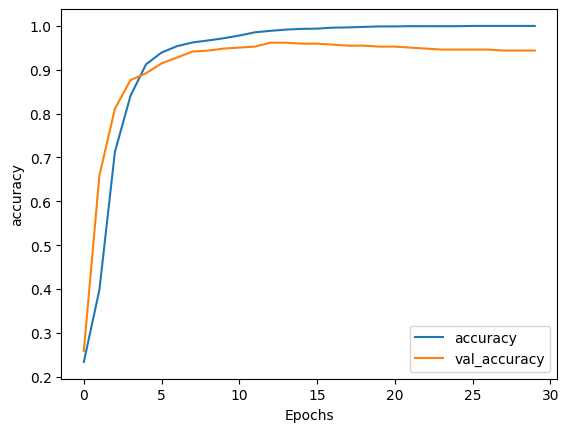

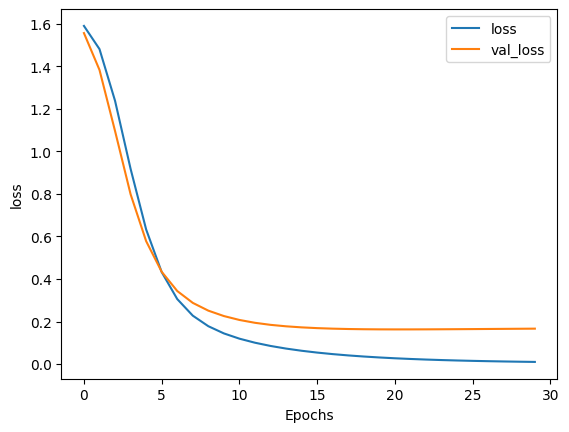

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")